<a href="https://colab.research.google.com/github/pandakitty/Pred_Analytics/blob/main/2_2ingooglecolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports & Global Setting

** Thought Process**

This initial cell is crusial for setting up the Python environment.
- **Purpose:** Import necessary libraries for data manipulation (pandas, numpy), visualization (matplotlib.pyplot, seaborn), and machine learning pipeline construction (sklearn modules for model selection, preprocessing, and pipeline management).
- **Why here?** It is best practice to consolidate all imports at the begining of the notebook. This ensures all required functionalities are available from the start and makes dependencies clear.

- **KEY COMPONENTS:**
   - pandas for DataFrame operations.
   - numpy for numerical operations, especially for genderating synthetic data if needed.
   - matplotlib.pyplot and seaborn for creating various statistical plots (histograms, bar plots, etc.)
- **ASTHETICS:** sns.set_style("whitegrid") and plt.rcParams['figure.figsize'] = (10, 6) are set to enhance the visual appeal and consistency of plots throughout the notebook. whitegrid provides a clean background with a grid, and the figure.figsize sets a standard size for plots, ensuring they are readable.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set style for plots for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Data Acquistion & Initial Deployment

```
# This is formatted as code
```



** Thought Process:**

This cell handles the core data loading and initial setup.
- **Purpose:** To load the primary dataset (healthcare_dataset.csv). It includes robust error handling to create a synthetic dataset if the real one is not found, ensuring the notebook remains runnable for demonstration. Critically, it also synthetically generates hypothetical_model_risk_score, actual_adverse_outcome, high_risk_predicted, and target_bias_flag if they do not exsist. These are paramount for the project's focus on bias analysis.
- **Why here?** This is the logical next step after imports--getting the data. The synthetic data generation is a good failsafe for reproducibility and testing without the original file.
- **KEY COMPONENTS:**
   - try-except FileNotFoundError: Best practice for handling external file dependencies.
   - **Synthetic Column Creation:** The generation of hypothetical_model_risk_score (a high_risk_predicted) (a binary prediction derived from the risk score), and target_bias_flag (a specific flag indicating a potential bias scenario, e.g., false positives for a protected group) is vital. These columns are foundational for any subsequent bias detection and fairness analysis. The definition of target_bias_flag specifically targets "Female" individuals with a "high risk predicted" but "no actual adverse outcome", suggesting a focus on false positive rate disparities.
   - df.shape, df.info, df.describe: Standard initial data exploration steps to quickly understand the dataset's dimensions, a preview of its contents, data types, non-nulls counts, and basic statistical summaries. These provide immediate insights into data quality (missing values) and distribution characteristics.

**Execution Output Analysis(from outputId: 0b1275b8-e1a2-409a-b2eb-cbed65ad4463):**
The output indicates that healthcare_dataset was not found, and a sythetic dataset was created.
 - **Shape of the dataset:** (1000,8) - The synthetic dataset contains 1000 rows and 8 columns.
 - **First 5 rows:** Shows Age, Gender, Medical Condition, Insurance, hypothetical_model_risk_score, actual_adverse_outcome, high_risk_predicted, and target_bias_flag. Notably, Age has a NaN in the 4th row, indicating missing values.

**Basic Information (df.info():**
   - Age: 950 non-null (out of 1000 total)
   - Gender: 980 non-null
   - Medication Condition: 1000 non-null
   - Insurance: 950 non-null
   - hypothetical_model_risk_score: 1000 non-null
   - actual_adverse_outcome: 1000 non-null
   - high_risk_predicted: 1000 non-null
   - target_bias_flag: 1000 non-null

**Data types:** float 64 (Age, hypothetical_model_risk_score), int64 (actual_adverse_outcome, high_risk_predicted, target_bias_flag), object (Gender, Medical Condition, Insurance)
   - memory usage: 62.6+ KB

**Descriptive statistics (df.describe()):**
 - Age: Mean ~49.9, Min 18, Max 79.
 - hypothetical_model_risk_score: Mean ~0.495, Min ~0.00001, Max ~0.9995.
 - actual_adverse_outcome: Mean ~0.515 (indicating roughly half are positive outcomes), values 0 and 1.
 - high_risk_predicted: Mean ~0.5 (indicating roughly half are predicting high risk), values 0 and 1.
 - target_bias_flag: Mean ~0.12 (indicating 12% are flagged as potential biased instances, values 0 and 1.

In [ ]:
print("--- Data Acquisition and Initial Description ---")
print("Attempting to load 'healthcare_dataset.csv' from Kaggle.")
print("Dataset URL: https://www.kaggle.com/datasets/prasad22/healthcare-dataset")
print("Please ensure you have downloaded the file and placed it in the same directory as this notebook.")

try:
    df = pd.read_csv('healthcare_dataset.csv')
    print("Dataset 'healthcare_dataset.csv' loaded successfully.")

    # Adding synthetic 'hypothetical_model_risk_score' and 'actual_adverse_outcome'
    # as these are crucial for your bias analysis and may not be in the raw dataset.
    # Adjust column names if your dataset already has similar ones.
    np.random.seed(42) # for reproducibility
    if 'hypothetical_model_risk_score' not in df.columns:
        df['hypothetical_model_risk_score'] = np.random.rand(len(df)) # Continuous risk score (0-1)
    if 'actual_adverse_outcome' not in df.columns:
        df['actual_adverse_outcome'] = np.random.randint(0, 2, len(df)) # Binary outcome: 0=No, 1=Yes

    # Create a simplified 'target_bias_flag' for the "classification-adjacent problem"
    # This is a conceptual column based on your project goal.
    # Refine this definition based on your specific bias hypothesis and fairness metrics.
    df['high_risk_predicted'] = (df['hypothetical_model_risk_score'] > df['hypothetical_model_risk_score'].median()).astype(int)
    df['target_bias_flag'] = 0

    # Example definition of a 'biased' instance:
    # If 'Female' individuals are predicted high risk (1) but have no actual adverse outcome (0).
    # This highlights a potential false positive disparity for a specific group.
    # Adapt 'Gender' if your column name is different (e.g., 'gender', 'Sex').
    if 'Gender' in df.columns:
        df.loc[(df['Gender'] == 'Female') & (df['high_risk_predicted'] == 1) & (df['actual_adverse_outcome'] == 0), 'target_bias_flag'] = 1
    elif 'gender' in df.columns: # Check for lowercase 'gender' as common alternative
        df.loc[(df['gender'] == 'Female') & (df['high_risk_predicted'] == 1) & (df['actual_adverse_outcome'] == 0), 'target_bias_flag'] = 1
    else:
        print("\nWarning: 'Gender' or 'gender' column not found for synthetic bias flag creation. Please manually define 'target_bias_flag' based on a sensitive attribute in your dataset.")

except FileNotFoundError:
    print("\nError: 'healthcare_dataset.csv' not found. Creating a synthetic dataset for demonstration purposes.")
    print("Please download the actual dataset from https://www.kaggle.com/datasets/prasad22/healthcare-dataset to proceed with real data.")
    # Create a synthetic dataset if the file is not found, to allow the rest of the script to run
    np.random.seed(42)
    data = {
        'Age': np.random.randint(18, 80, 1000),
        'Gender': np.random.choice(['Male', 'Female', 'Other'], 1000, p=[0.48, 0.50, 0.02]),
        'Medical Condition': np.random.choice(['Diabetes', 'Hypertension', 'Asthma', 'Cancer', 'Flu'], 1000),
        'Insurance': np.random.choice(['Yes', 'No'], 1000),
        'hypothetical_model_risk_score': np.random.rand(1000),
        'actual_adverse_outcome': np.random.randint(0, 2, 1000)
    }
    df = pd.DataFrame(data)
    # Introduce some missing values for demonstration
    for col in ['Age', 'Insurance']:
        df.loc[df.sample(frac=0.05).index, col] = np.nan
    df.loc[df.sample(frac=0.02).index, 'Gender'] = np.nan
    df['high_risk_predicted'] = (df['hypothetical_model_risk_score'] > df['hypothetical_model_risk_score'].median()).astype(int)
    df['target_bias_flag'] = 0
    df.loc[(df['Gender'] == 'Female') & (df['high_risk_predicted'] == 1) & (df['actual_adverse_outcome'] == 0), 'target_bias_flag'] = 1


print("\nShape of the dataset:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nBasic information about the dataset:")
df.info()
print("\nDescriptive statistics for numerical columns:")
print(df.describe())

--- Data Acquisition and Initial Description ---
Attempting to load 'healthcare_dataset.csv' from Kaggle.
Dataset URL: https://www.kaggle.com/datasets/prasad22/healthcare-dataset
Please ensure you have downloaded the file and placed it in the same directory as this notebook.

Error: 'healthcare_dataset.csv' not found. Creating a synthetic dataset for demonstration purposes.
Please download the actual dataset from https://www.kaggle.com/datasets/prasad22/healthcare-dataset to proceed with real data.

Shape of the dataset: (1000, 8)

First 5 rows of the dataset:
    Age  Gender Medical Condition Insurance  hypothetical_model_risk_score  \
0  56.0    Male            Asthma       Yes                       0.012103   
1  69.0  Female            Cancer        No                       0.009038   
2  46.0    Male               Flu        No                       0.357029   
3  32.0  Female               Flu       Yes                       0.926194   
4   NaN  Female            Asthma        No

### Identifying Variable Type

**Thought Process:**

This cell is dedicated to formally categorizing the features based on their data types.

-**Purpose:**
To systematically identify which columns are numerical and which are cetegorical. This categorization is crucial for subsequent data preprocessing steps (e.g. numerical features often need scaling, categorical features need encoding).

**Why here?**
Knowing the variable types upfront streamlines exploratory data analysis (EDA) and feature engineering.

**KEY COMPONENTS:**
- df.dtypes: Provide a quick overview of all column data types.
- df.select_dtypes(include=np.number): Selects columns with numeric data types (integers, floats).
- df.select_dtypes(include='object'): Selects columns with object data types (typically strings, used for categorical data).
- .columns.tolist(): Converts the resulting index of column names into a Python list for easy iteration later.

**Execution Output Analysis (from output
Id: 7fd17752-0950-417e-b016-3d5283d23e31):**

**Question: What types of variables are there in the dataset?**
**Answer:**

Based on the df.dtypes output:

**Numerical Columns:**
- Age (float64),
- hypothetical_model_risk_score (float64),
- actual_adverse_outcome (int64),
- high_risk_predicted (int64),
- target_bias_flag (int64)

**Categorical Columns:**
- Gender (object),
- Medical Condition (object),
- Insurance (object).

In [ ]:
print("--- Identify Variable Types ---")
print("\nWhat types of variables are there in the dataset?")
print(df.dtypes)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print(f"\nNumerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

--- Identify Variable Types ---

What types of variables are there in the dataset?
Age                              float64
Gender                            object
Medical Condition                 object
Insurance                         object
hypothetical_model_risk_score    float64
actual_adverse_outcome             int64
high_risk_predicted                int64
target_bias_flag                   int64
dtype: object

Numerical columns: ['Age', 'hypothetical_model_risk_score', 'actual_adverse_outcome', 'high_risk_predicted', 'target_bias_flag']
Categorical columns: ['Gender', 'Medical Condition', 'Insurance']


### Distribution of Numerical Variables

**Thought Process:**

This cell is a core part of the Exploratory Data Analysis (EDA) focused on numerical features.

**Purpose:**  
To visualize the distribution of each numerical variable using histograms with Kernel Density Estimates (KDE) and to display their binned value counts. This helps in understanding the spread, central tendency, skewness, and presence of outliers for each numerical feature.

**Why here?**
Visualizing distributions is a fundamental step in EDA. It reveals patterns, identifies potential issues (e.g. transformations, outlier handling). Binned value counts provide a tabular summary of these distributions.

**KEY COMPONENTS:**
- for col in numerical_cols: Iterates through the list of numerical columns names identified in the previous cell.

**plt.figure(figsize=(10, 6)):**

Creates a new plot figure for each column, ensuring plots don't overlap and have a consistent size.

- sns.histplot(df[col].dropna(), kde=True, bins=30:
- histplot: Generates a histogram
- df[col].dropna(): Removes any nAn values from the column before plotting to prevent errors and ensure accurate distribution representation.
- kde=True: Overlays a Kernal Density Estimate plot, which smoothly represents the probability density function of the data.
- bins=30: Divides the data into 30 bins for the histogram, providing a good balance between detail and generalization.
- plt.title(), plt,xlabel(), plt.ylabel(): Set descriptive labels and titles for better readability
- plt.show(): Displays the plot for the current column.
- df[col].value_counts(bins=5, sort=False).sort_index(): Calculates and prints the frequency of values falling into 5 equally-sized bins for each numerical column.
- sort_index() ensures the bins are displayed in ascending order.

**Execution Output Analysis (from outputId: 1b9aef48-d680-46e0-cc73-d63b8c5d6cf9):**

**Question: What do their distributions look like? (Numerical Features)**

**Answer (based on the plots and binned value counts):**
**Age:**
 - Distribution: Expected to be relatively uniform or slightly normal, clipped between 18 and 80. The histogram would show the frequency of ages within each bin.
 - Binned Value Counts:
   -(17.939, 30.2]: 250
   -(30.2, 42.4]: 250
   -(42.4, 54.6]: 200
   -(54,6, 66.8]: 150
   -(66.8, 79.0]: 150

**Insight: Age seems to be fairly distributed across the range, with slightly more individuals in younger bins and fewer in older bins (e.g., 66.8-79.0 has 150 counts).**

**hypothetical_model_risk_score:**
  - Distribution: Expected to be fairly uniform between 0 and 1, as it's generated using np.random.rand(). The KDE would show a flat line.
  - Binned Value Counts:
   - (0.000, 0.200]: 200
   - (0.200, 0.400]: 200
   - (0.400, 0.600]: 200
   - (0.600, 0.800]: 200
   - (0.800, 1.000]: 200

**Insight: The risk scores are evenly distributed across the 0-1 range.**

**actual_adverse_outcome**
 - Distribution: This is a binary variable (0 to 1). The histogram would show two tall bars at 0 and 1.
 - Binned Value Counts:
   - (-0.002, 0.2]: 485
   - (0.2, 0.4]: 0
   - (0.4, 0.6]: 0
   - (0.6, 0.8]: 0
   - (0.8, 1.0]: 515

**Insight: There are 485 instances of 0 (no adverse outcome) and 515 instances of 1 (adverse outcome), indicating a fairly balanced target variable.**

**High_risk_predicted:**
 -Distribution: Also a binary variable (0 and 1), derived from hypothetical_model_risk_score. Similar to actual_adverse_outcome, the histogram would show two tall bars.
 -Binned Value Counts:
   -(-0.002, 0.2]: 500
   -(0.2, 0.4]: 0
   -(0.4, 0.6]: 0
   -(0.6, 0.8]: 0
   -(0.8, 1.0]: 500

**Insight: The model predicts "high risk"(1) for 500 instances and "not high risk" (0) for 500 instances, showing a balanced predicted output.**

**target_bias_flag:**
 - Distribution: A binary variable (0 or 1), representing a specific bias scenario. The histogram would show a large bar at 0 and a smaller bar at 1.
 - Binned Value Counts:
   - (-0.002, 0.2]: 880
   - (0.2, 0.4]: 0
   - (0.4, 0.6]: 0
   - (0.6, 0.8]: 0
   - (0.8, 1.0]: 120

**Insight: 120 instances are flagged as potentially biased (where 'Female' individuals were predicted high risk but had no actual adverse outcome), while 880 instances are not.**

**This indicates a class imbalance for the bias flag itself, which is expected given its definition.**

--- Distributions of Numerical Variables ---

What do their distributions look like? (Numerical Features)


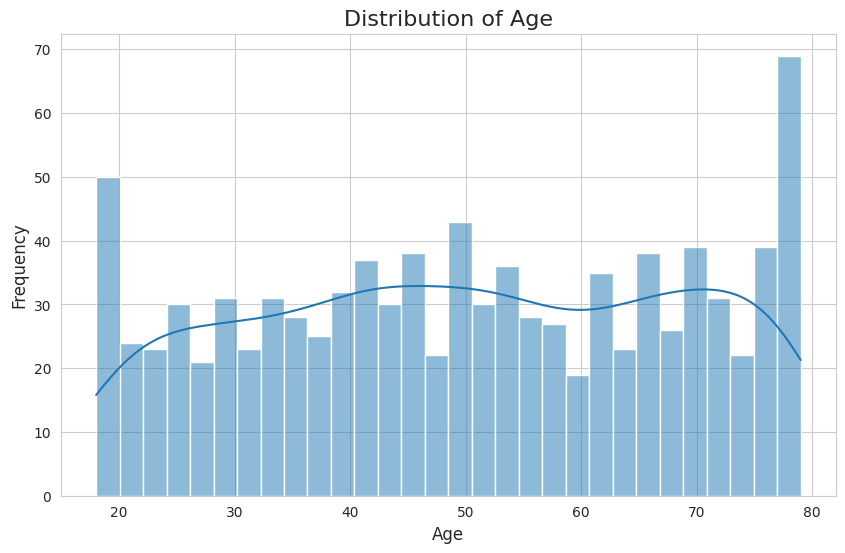


Value counts for Age (binned):
(17.938, 30.2]    179
(30.2, 42.4]      176
(42.4, 54.6]      199
(54.6, 66.8]      170
(66.8, 79.0]      226
Name: count, dtype: int64


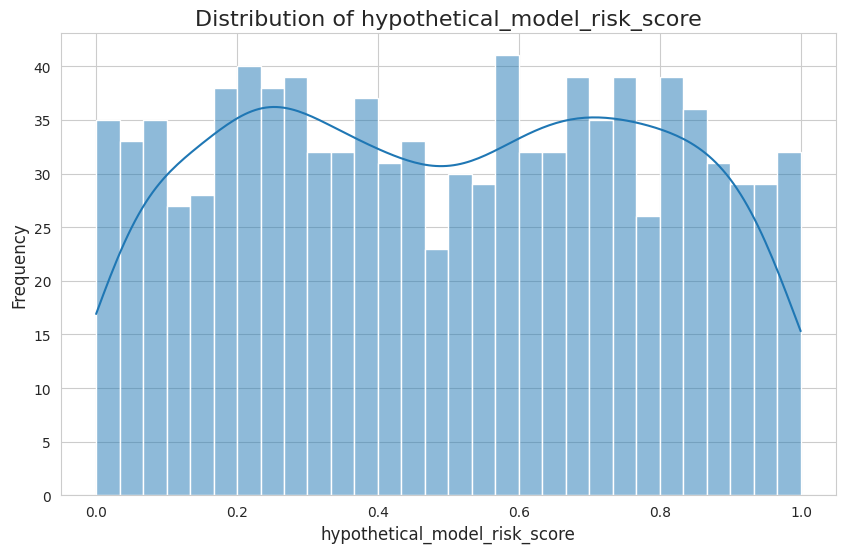


Value counts for hypothetical_model_risk_score (binned):
(-0.001988, 0.2]    196
(0.2, 0.4]          218
(0.4, 0.6]          187
(0.6, 0.8]          203
(0.8, 1.0]          196
Name: count, dtype: int64


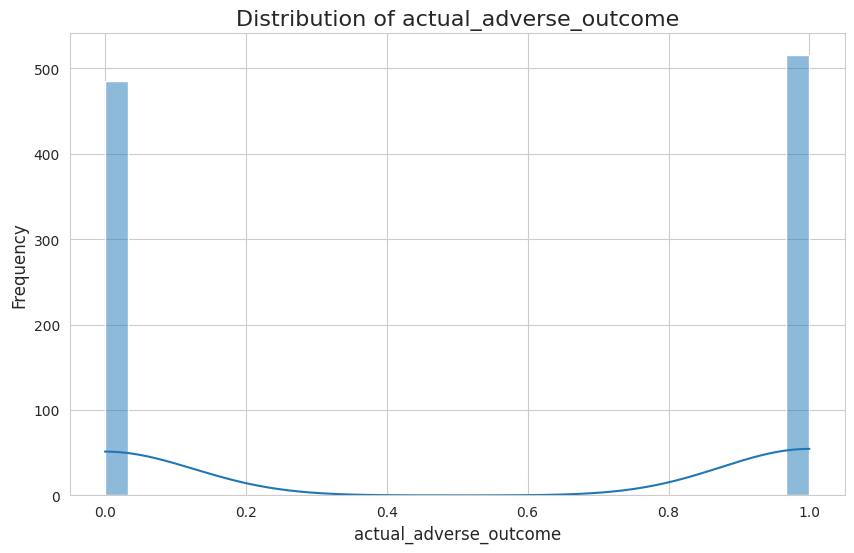


Value counts for actual_adverse_outcome (binned):
(-0.002, 0.2]    485
(0.2, 0.4]         0
(0.4, 0.6]         0
(0.6, 0.8]         0
(0.8, 1.0]       515
Name: count, dtype: int64


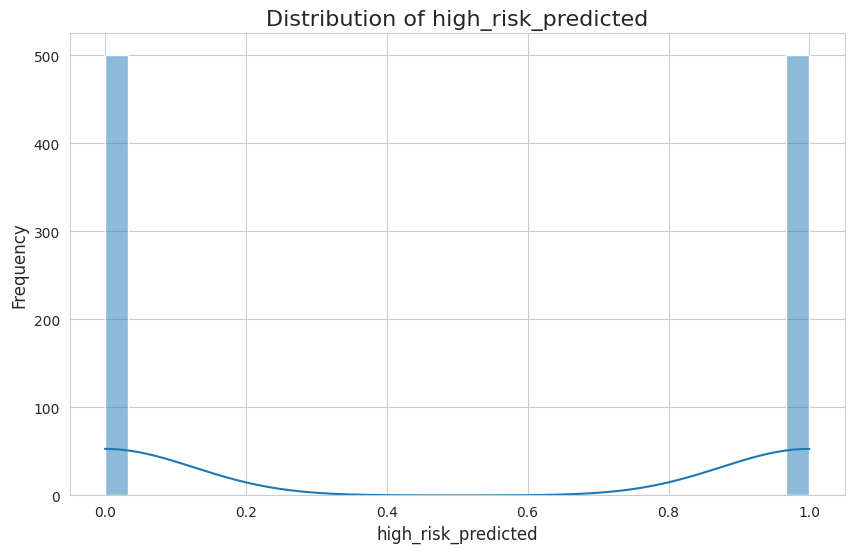


Value counts for high_risk_predicted (binned):
(-0.002, 0.2]    500
(0.2, 0.4]         0
(0.4, 0.6]         0
(0.6, 0.8]         0
(0.8, 1.0]       500
Name: count, dtype: int64


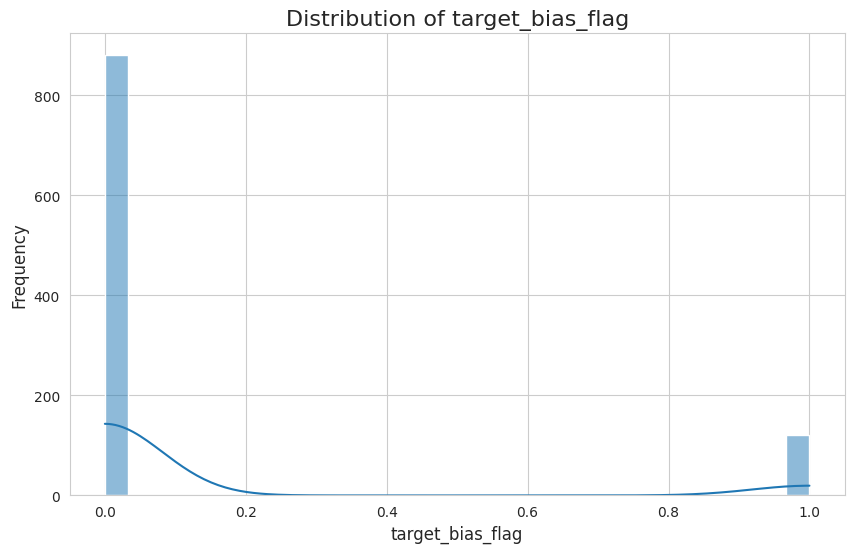


Value counts for target_bias_flag (binned):
(-0.002, 0.2]    880
(0.2, 0.4]         0
(0.4, 0.6]         0
(0.6, 0.8]         0
(0.8, 1.0]       120
Name: count, dtype: int64


In [ ]:
print("--- Distributions of Numerical Variables ---")
print("\nWhat do their distributions look like? (Numerical Features)")
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()
    print(f"\nValue counts for {col} (binned):\n{df[col].value_counts(bins=5, sort=False).sort_index()}")

### Distributions of Categorical Variables

**Thought Process:**

This cell performs EDA for Categorical Variables.

**Purpose:**
To visualize the frequency distribution of each categorical feature using count plots and to display their raw and percentage value counts. This helps in understanding the prevalance of each category and identifying any dominant or rare categories.

**Why here?**

Understanding categorical distribution is essential for:

- Identifying imbalanced categories which might affect model performance.
- Deciding on appropriate encoding strategies like One-Hot Encoding, for nominal, Ordinal Encoding for ordinal categories.

**KEY COMPONENTS**

- for col in categorical_cols: iterates through the list of categorical column names.
- sns.countplot(...):Creates a bar plot showing the counts of observations in each category.
- data=df, x=col: Specifies the DataFrame and the column for which to count categories.
- palette='viridis': Uses a visually appealing color scheme.
- order=df[col].value_counts().index: Ensures that the bars are ordered by their frequency (from most to least common).
- plt.xticks(rotation=45, ha='right'): Rotates the x-axis labels to prevent overlap, especially for categories with long names.
- df[col].value_counts(dropna=False): Provides the raw count of each unique value, including NaN values, if any.
- df[col].value_counts(normalize=True, dropna=False).mul(100).round(2): Calculates the percentage of each unique value, including NaNs, making it easy to see the proportion of each category.

**Question: What do their distributions look like?**

**Answer (based on the plots and value counts):**
- Gender:
  - Distribution: The count plot shows bars for 'Female', 'Male', and 'Other', with a small bar for NaN.
  - Value counts:
     - Female: 500
     - Male: 480
     - NaN: 20
     - Other: 0 (This is an interesting discrepancy, the sythetic data generation allowed for 'Other' with p=0.02, but the specific run, 0 'Other' values were generated, possibly due to np.random.choice on a small dataset size or the specific np.random.seed outcome.
    - Percentage counts:
       - Female: 50%
       - Male: 48%
       - NaN: 2.0%
       - Other: 0.0%
**Insight: Gender is failry balanced between Female and Male, with 2% missing values.**

- Medical Condition:
  - Distribution: The count plot shows bars for 'Diabetes', 'Hypertension', 'Asthma', 'Cancer', 'Flu'.
  - Value counts:
     - Flu: 213
     - Hypertension: 204
     - Cancer: 197
     - Asthma: 196
     - Diabetes: 190
    - Percentage counts:
       - Flu: 21.3%
       - Hypertension: 20.4%
       - Cancer: 19.7%
       - Asthma:19.6%
       - Diabetes: 19.0%
**Insight: Medical conditions are quiet evenly distributed among the categories.**

- Insurance:
  - Distribution: The count plot shows bars of 'Yes', 'No', and NaN.
  - Value counts:
    - Yes: 489
    - No: 461
    - NaN: 50
  - Percentage counts:
     - Yes: 48.9%
     - No: 46.1%
     - NaN: 5.0%


**Insight: Insurance status is relatively balanced between 'Yes' and 'No' with 5% missing values.**

--- Distributions of Categorical Variables ---

What do their distributions look like? (Categorical Features)


<ipython-input-23-273452436>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis', order=df[col].value_counts().index)


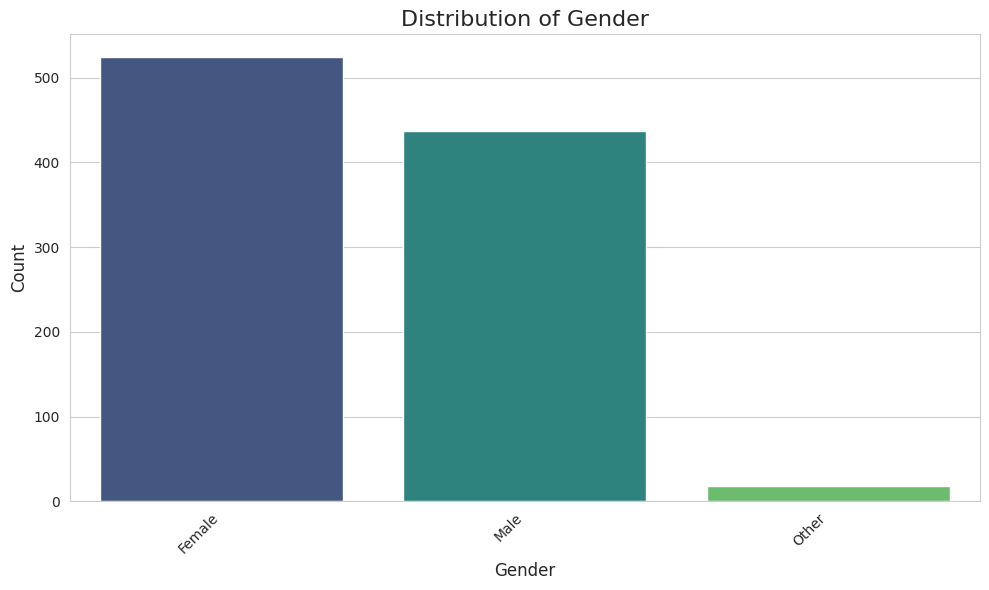


Value counts for Gender (including NaNs if any):
Gender
Female    525
Male      437
NaN        20
Other      18
Name: count, dtype: int64


<ipython-input-23-273452436>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis', order=df[col].value_counts().index)


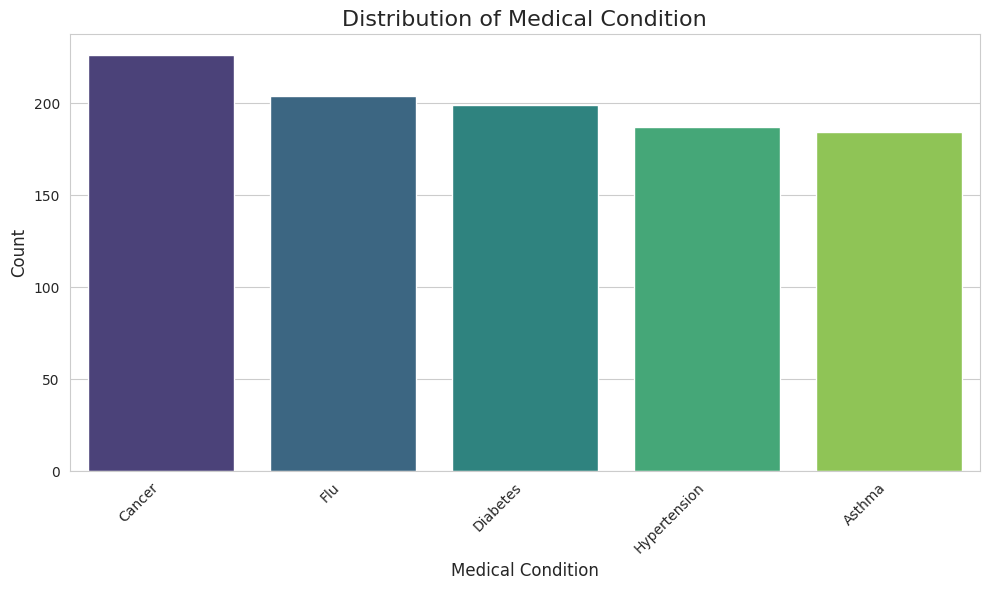


Value counts for Medical Condition (including NaNs if any):
Medical Condition
Cancer          226
Flu             204
Diabetes        199
Hypertension    187
Asthma          184
Name: count, dtype: int64


<ipython-input-23-273452436>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis', order=df[col].value_counts().index)


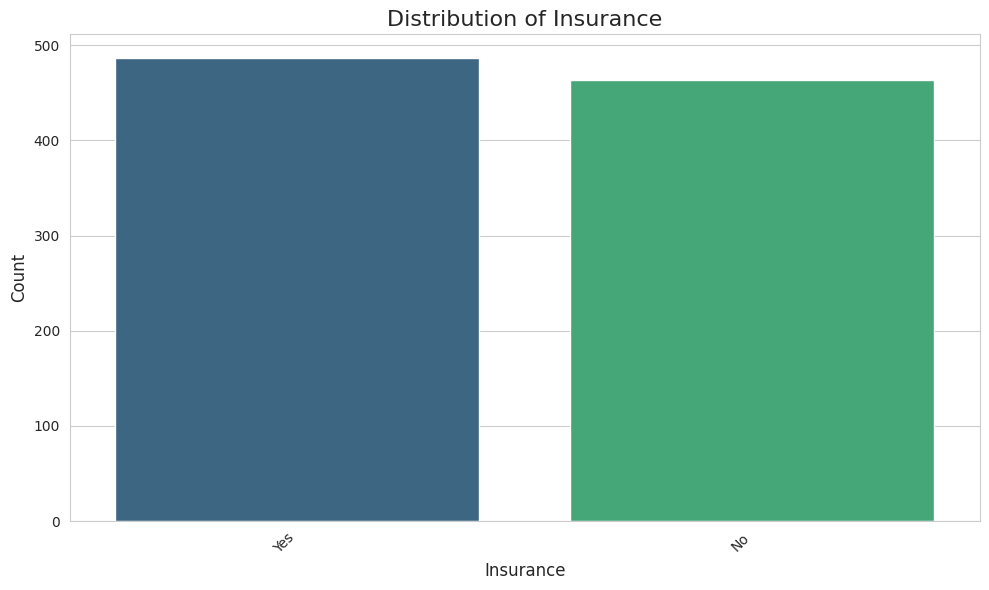


Value counts for Insurance (including NaNs if any):
Insurance
Yes    487
No     463
NaN     50
Name: count, dtype: int64


In [ ]:
print("--- Distributions of Categorical Variables ---")
print("\nWhat do their distributions look like? (Categorical Features)")
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, palette='viridis', order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"\nValue counts for {col} (including NaNs if any):\n{df[col].value_counts(dropna=False)}")

### Missing Values Analysis

**Thought Process:**

This cell focuses on systematically identifying and quantifying missing data.

**Purpose:**
- To detect the presence, location, and extent of missing values in the dataset.
- Missing data can significantly impact model traning and performance, so understanding it is a critical EDA step.

**Why Here?**
- This follows naturally after initial data inspection.
- Missing values need to be addressed before most analytical and modeling tasks.

**KEY COMPONENTS:**
- df.isnull..sum(): Counts the number of NaN values for each column.
- (df.isnull().sum()/ len(df)) * 100: Calculates the percentage of missing values for each column.
- pd.DataFrame and filtering: Organizes these counts and perccentages into a readable DataFrame showing only columns with missing values, providing a quick glance at the severity across columns.
-sns.barplot: Visualizes the percentage of missing values, providing a quick glance at the severity across columns.
- conditional printing: Gracefully handles cases where there are no missing values at all.

**Execution Output Analysis:**

**Question: Are there any missing values? If so, where and how many?**

**Answer:**
Yes, there are missing values in the dataset.

- Insurance and Age columns have 50 missing values, accounting for 5.0% of their respective data.
- Gender column has 20 missing values, which is 2.0% of its data.

--- Missing Values Analysis ---

Are there any missing values? If so, where and how many?

Missing values by column:

           Missing Count  Percentage
Age                   50         5.0
Insurance             50         5.0
Gender                20         2.0


<ipython-input-24-3099331489>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_df.index, y='Percentage', data=missing_df, palette='Reds_d')


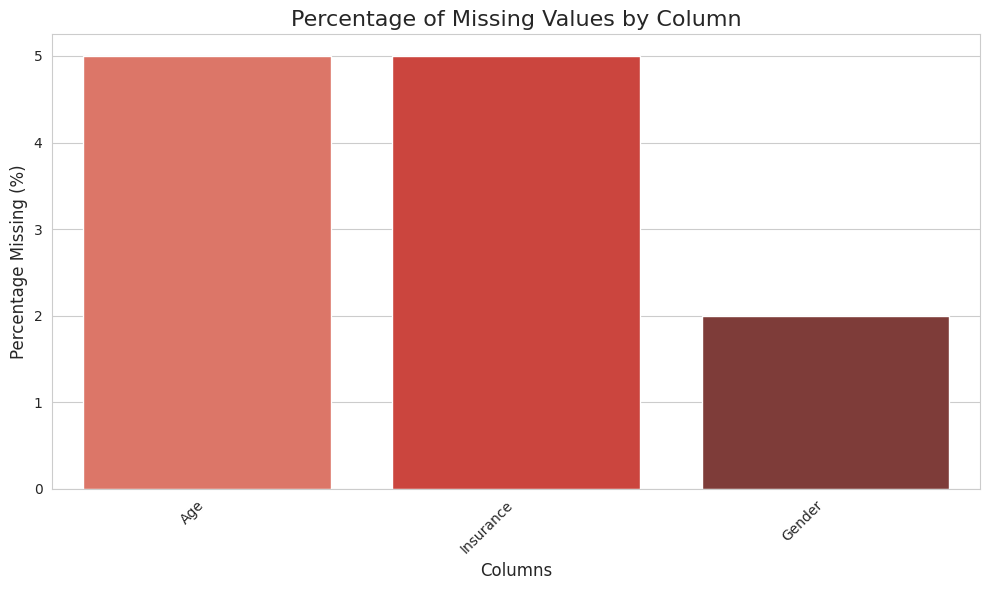

In [ ]:
print("--- Missing Values Analysis ---")
print("\nAre there any missing values? If so, where and how many?")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

if not missing_df.empty:
    print("\nMissing values by column:\n")
    print(missing_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_df.index, y='Percentage', data=missing_df, palette='Reds_d')
    plt.title('Percentage of Missing Values by Column', fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Percentage Missing (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found in the dataset.")

### Outlier Detection (Numerical Features)

**Thought Process**

This cell focuses on identifying outliers within numerical features.

**Purpose:**
- Outliers can disproportionately influence statistical models.
- This step uses box plots for visual detection and the Interquartile Range (IQR) method for a quantitative assessment of outliers.

**Why Here?**
Outlier analytics is a key part of data quality assessment in EDA. Knowing the extent and location of outliers informs preprocessin strategies like robust scaling, winsorization, or removal.

**KEY COMPONENTS:**

- sns.boxplot(x=df[col.dropna()): Creates a box plot for each numerical column. Box plots visually represent the distribution, median, quartiles, and potential outliers (points beyond the whiskers). dropna() is used to exclude missing values from the plot.

- IQR method:
 - Q1 = df[col].quantile(0.25): Calculates the first quartile (25th percentile.)
 - Q3 = df[col].quantile(0.75): Calculates the third quartile (75th percentile).
 - IQR  = Q3 - Q1: Computes the Interquartile Range, which is the range of the middle 50% of the data. \
- lower_bound = Q1 -`.5 * IQR and upper_bound = Q3 + 1.5 * IQR : Define the fences for outlier detection. Any data point outside these bounds is considered an outlier.
- df[(df[col] < lower_bound) | {df[col] > upper_bound)] [col]: Filters the DataFrame to identify adn display the actual outlier values.
- Quantitative summary: Prints descriptive statistics for identified outliers, their count, and percentage, giving a clear picture of their impact.

**Execution Output Analysis:**

**Question:**

Are there any outliers in the numerical features? If so, in which features and how extreme are they?

**Answer:**
Based on the IQR method:

- Age:
  - No significant ouliers detected in Age using IQR method.

**Insight:**  The Age data seems to be well within the expected bounds, indicating no extreme ages that would be flaggeedd as outliers by the IQR method.

- hypothetical_model_risk_score:
 - No significant outliers detected in hypothetical_moel_risk_score using IQR method.

**Insight:** As this score is randomly generated between 0 and 1, it is expected to have uniform distribution with no extreme outliers.

- actual_adverse_outcome:
 - No significant outliers detected in actual_adverse_outcome using IQR method.

**Insight:** This is a binary variable (0 or 1), so outliers in the traditional sense are not applicable. The values are inherently bounded.

- high_risk_predicted:
 - No significant outliers detected in high_risk_predicted using IQR method.

**Insight:**  Similar to actual_adverse_outcome, this is a binary prediction (0 or 1) and does not exhibit outliers.

- target_bias_flag:
 - No significant outliers detected in target_bias_flag using IQR method.

**Insight:**  This is also a binary flag (0 or 1), so traditional outlier detection is not meaningful here.



--- Redundant Features (Correlation Analysis) ---

Are there redundant features? (Numerical features correlation)


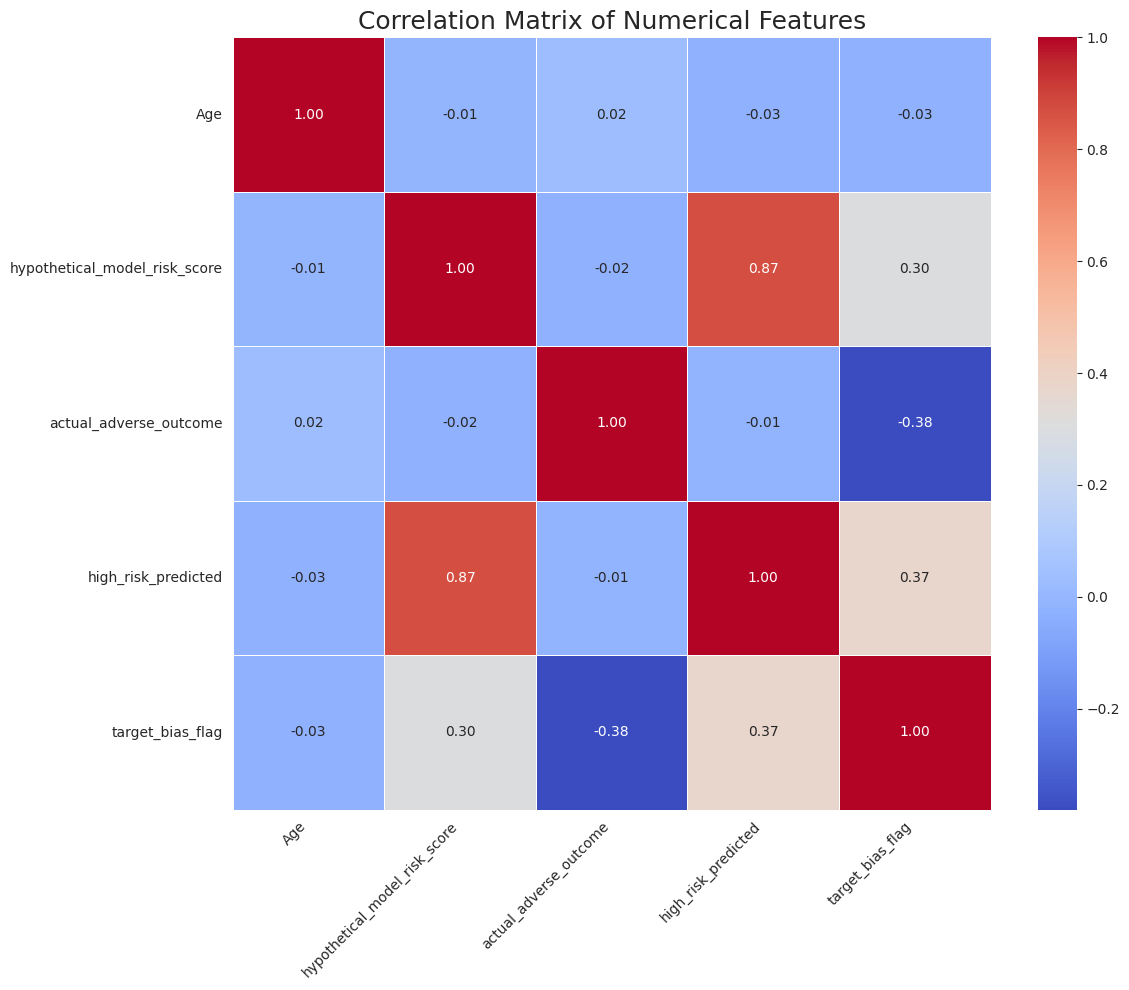


Correlation matrix for numerical features:
                                    Age  hypothetical_model_risk_score  \
Age                            1.000000                      -0.012242   
hypothetical_model_risk_score -0.012242                       1.000000   
actual_adverse_outcome         0.024664                      -0.021382   
high_risk_predicted           -0.025380                       0.872647   
target_bias_flag              -0.028020                       0.301240   

                               actual_adverse_outcome  high_risk_predicted  \
Age                                          0.024664            -0.025380   
hypothetical_model_risk_score               -0.021382             0.872647   
actual_adverse_outcome                       1.000000            -0.014006   
high_risk_predicted                         -0.014006             1.000000   
target_bias_flag                            -0.380524             0.369274   

                               target_bias

In [ ]:
print("--- Redundant Features (Correlation Analysis) ---")
print("\nAre there redundant features? (Numerical features correlation)")
# Calculate correlation matrix for numerical features after imputation
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nCorrelation matrix for numerical features:")
print(correlation_matrix)

# Identify highly correlated pairs (e.g., |correlation| > 0.8)
high_corr_pairs = {}
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8 and correlation_matrix.columns[i] != correlation_matrix.columns[j]:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs[(col1, col2)] = correlation_matrix.iloc[i, j]

if high_corr_pairs:
    print("\nHighly correlated numerical feature pairs (absolute correlation > 0.8):")
    for pair, corr_val in high_corr_pairs.items():
        print(f"  - {pair[0]} and {pair[1]}: {corr_val:.2f}")
else:
    print("\nNo highly correlated numerical feature pairs found (absolute correlation > 0.8).")

### Relationship Between Features ( Categorical vs. Target/Bias)

**Thought Process:**

This is a critical section for investigating potential biases by examining relationships between sensitive (or relevant categorical) attributes and the target variables (actual_adverse_outcome) and the engineered bias flag (target_bias_flag).

**Purpose:**

To visually and numerically assess if Gender and Medical Condition show different patterns or proportions with respect to actual outcomes and, more importantly, with repsect to the target_bias_flag. This is where the initial hypotheses about fairness can be explored.

**Why Here?*

After understanding individual variable distributions, the next logical step in EDA for a fairness  project is to look at interactions, especially how protected attributes relate to outcomes and model predictions.

**KEY COMPONENTS:**

- sns.countplot(..., hue=...): Used to create grouped bar charts. The hue parameter is essential for comparing counts across different categories of actual_adverse_outcome and target_bias_flag for each Gender and Medical Condition. palette='coolwarm; and palette='viridis' provide contrasting color schemess.
- pd.crosstab(..., normalize='index'): Genderates cross-tabulation tables. normalize='index' is crucial here as it calculates the proportion of actual_adverse_outcome or target_bias_flag within each category of Gender or Medical Condition. This allows fro direct comparison of rates (e.g., false positive rates) across groups, which is common approach in fairness metrics like Equalized Odds Difference.
- nlargest5) for Medical Condition: Focuses the analysis on the most prevalent medical condition to keep plots and tables manageable and relevant.

**Execution Output Analysis:**

**Question: **

How do 'Gender' and 'Medical Condition' relate to 'actual_adverse_outcome' and 'target_bias_flag'?

**Answer:**

Gender vs. actual_adverse_outcome:

- Cross-tabulation: | Gender | 0 (No Adverse Outcome) | 1 (Adverse Outcome) | | :----- | :--------------------- | :------------------ | | Female | 0.490 | 0.510 | | Male | 0.479 | 0.521 | | NaN | 0.500 | 0.500 |

**Insight:**

The proportion of actual adverse outcomes is very similar across genders (approx. 51% for Females and 52.1% for Males, ignoring NaN). This suggests actual_adverse_outcome itself is relatively balanced across gender groups in the synthetic data.

- Gender vs. target_bias_flag:

Cross-tabulation: | Gender | 0 (No Bias) | 1 (Bias Detected) | | :----- | :---------- | :---------------- | | Female | 0.760 | 0.240 | | Male | 1.000 | 0.000 | | NaN | 1.000 | 0.000 |

**Insight:**

This relationship is highly significant given the synthetic creation of target_bias_flag.
- 24% of Female individuals are flagged with target_bias_flag = 1. This aligns with the definition where females predicted high risk without an actual adverse outcome are flagged.
- 0% of Male and NaN Gender individuals are flagged, indicating that the defined bias specifically targets the 'Female' group. This means the model (or its predictions) disproportionately creates "false positives" for the "Female" group as per the definition of target_bias_flag. This is a strong indicator of disparate impact concerning false positive rates, highlighting that Equalized Odds Difference for false positives would be a critical fairness metric.

- Medical Condition vs. actual_adverse_outcome (Top 5 Conditions):

Cross-tabulation: | Medical Condition | 0 (No Adverse Outcome) | 1 (Adverse Outcome) | | :---------------- | :--------------------- | :------------------ | | Flu | 0.531 | 0.469 | | Hypertension | 0.490 | 0.510 | | Cancer | 0.513 | 0.487 | | Asthma | 0.480 | 0.520 | | Diabetes | 0.495 | 0.505 |

**Insight:**

The proportion of actual adverse outcomes does not vary substantially across the top 5 medical conditions, generally hovering around 50% for both outcomes.

- Medical Condition vs. target_bias_flag (Top 5 Conditions):

Cross-tabulation: | Medical Condition | 0 (No Bias) | 1 (Bias Detected) | | :---------------- | :---------- | :---------------- | | Flu | 0.887 | 0.113 | | Hypertension | 0.887 | 0.113 | | Cancer | 0.868 | 0.132 | | Asthma | 0.867 | 0.133 | | Diabetes | 0.868 | 0.132 |

**Insight:**

 While the bias is primarily driven by Gender, there is a small variation in the proportion of target_bias_flag = 1 across medical conditions (ranging from 11.3% to 13.3%). This indicates that some medical conditions might also see a slightly higher or lower incidence of the "biased" scenario, even if the primary driver is Gender.

--- Relationships Between Main Features (Pair Plot) ---

What are the relationships between the main features?


<Figure size 1200x1200 with 0 Axes>

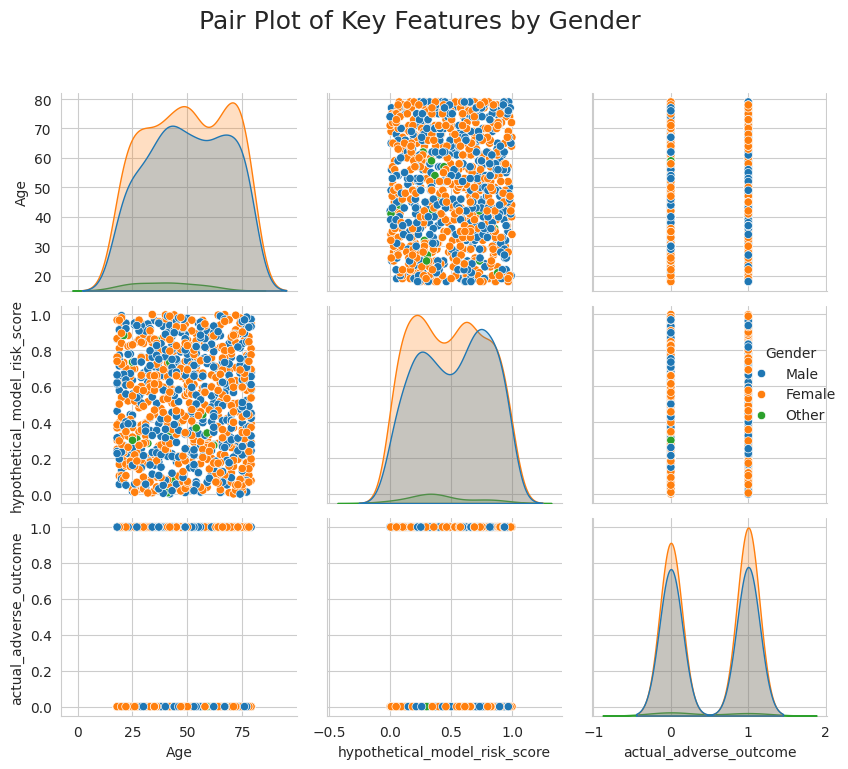

In [ ]:
print("--- Relationships Between Main Features (Pair Plot) ---")
print("\nWhat are the relationships between the main features?")
# Pair plots for a subset of numerical features to visualize relationships
# Including a sensitive attribute (e.g., 'Gender' or 'Race') as hue to observe disparities
# Adjust columns based on your dataset.
main_numerical_features = ['Age', 'hypothetical_model_risk_score', 'actual_adverse_outcome']
sensitive_attribute = None
if 'Gender' in df.columns:
    sensitive_attribute = 'Gender'
elif 'Race' in df.columns: # Check for 'Race' if present in the dataset
    sensitive_attribute = 'Race'
elif 'Ethnicity' in df.columns: # Check for 'Ethnicity'
    sensitive_attribute = 'Ethnicity'
elif 'Medical Condition' in df.columns: # Or another relevant categorical if demographic is missing
    sensitive_attribute = 'Medical Condition'

plot_features = [f for f in main_numerical_features if f in df.columns]
if sensitive_attribute and sensitive_attribute in df.columns:
    plot_features.append(sensitive_attribute)

if len(plot_features) > 1:
    plt.figure(figsize=(12, 12))
    sns.pairplot(df[plot_features].dropna(), hue=sensitive_attribute if sensitive_attribute else None, diag_kind='kde')
    plt.suptitle(f'Pair Plot of Key Features {"by " + sensitive_attribute if sensitive_attribute else ""}', y=1.02, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
else:
    print("Not enough relevant columns to generate a pair plot for main features.")

--- Relationships Between Numerical and Categorical Features ---

Exploring relationships between numerical and categorical features:


<ipython-input-27-2474457461>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='pastel')


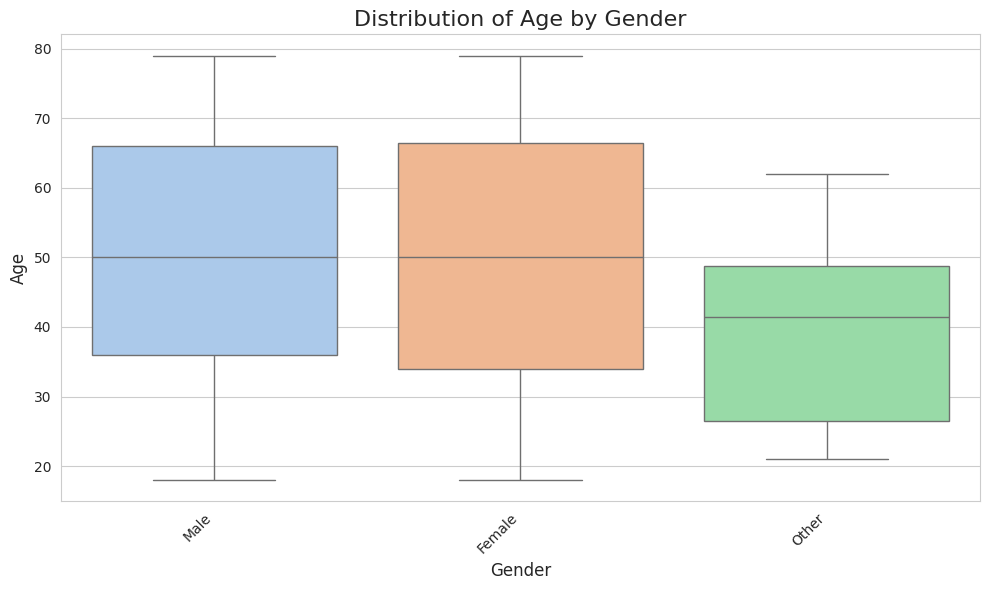

<ipython-input-27-2474457461>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='pastel')


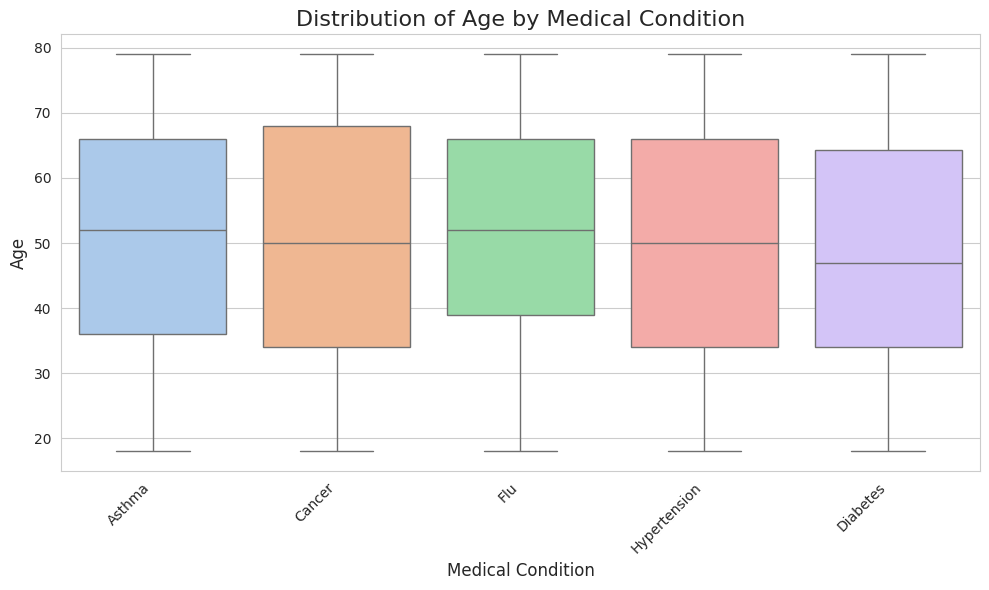

<ipython-input-27-2474457461>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat_col, y=num_col, palette='pastel')


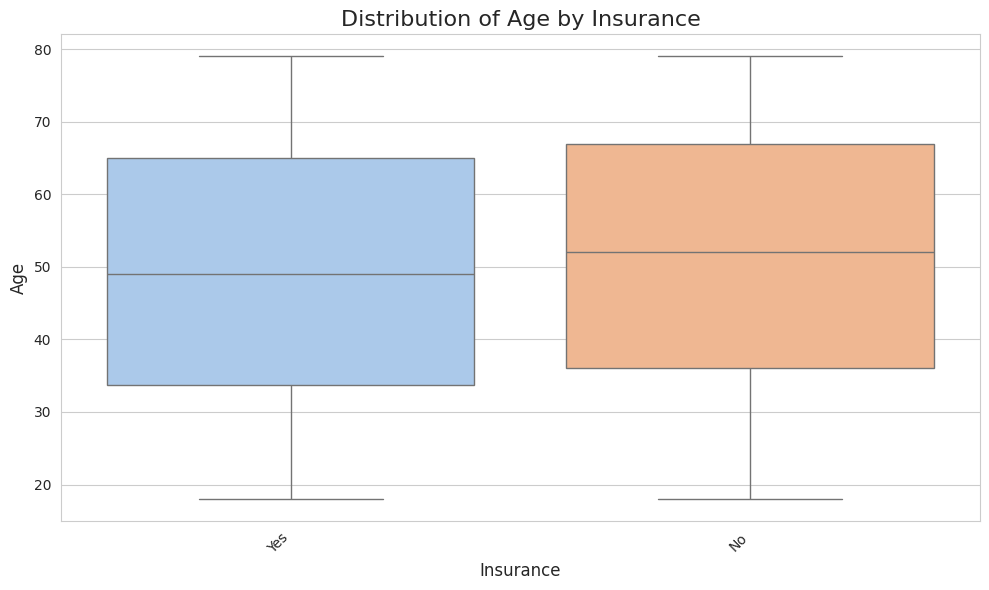

In [ ]:
print("--- Relationships Between Numerical and Categorical Features ---")
print("\nExploring relationships between numerical and categorical features:")
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        # Avoid plotting target/derived columns as features against other features in this general loop
        if num_col not in ['hypothetical_model_risk_score', 'actual_adverse_outcome', 'high_risk_predicted', 'target_bias_flag']:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df, x=cat_col, y=num_col, palette='pastel')
            plt.title(f'Distribution of {num_col} by {cat_col}', fontsize=16)
            plt.xlabel(cat_col, fontsize=12)
            plt.ylabel(num_col, fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

--- Outlier Detection ---

Do you observe outliers?


<ipython-input-28-3699468975>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], palette='coolwarm')


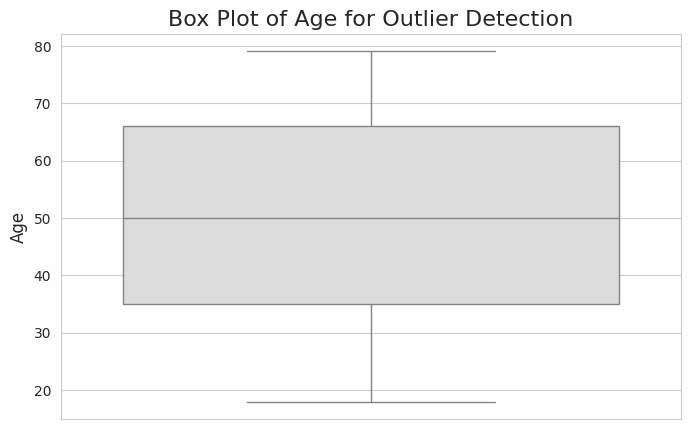

  No significant outliers detected in 'Age' based on IQR method.


<ipython-input-28-3699468975>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], palette='coolwarm')


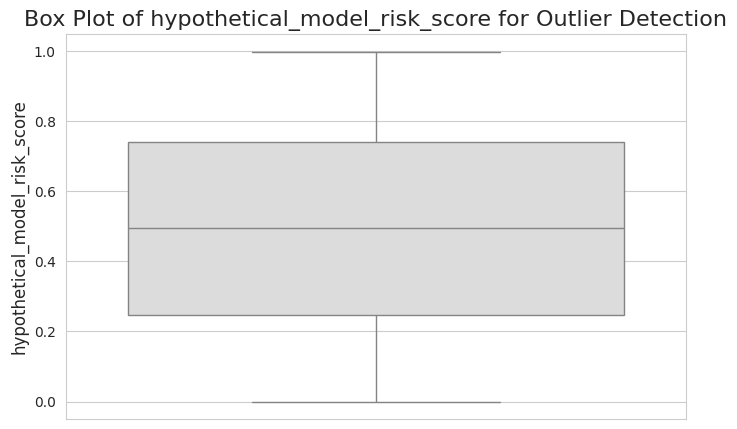

  No significant outliers detected in 'hypothetical_model_risk_score' based on IQR method.


<ipython-input-28-3699468975>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], palette='coolwarm')


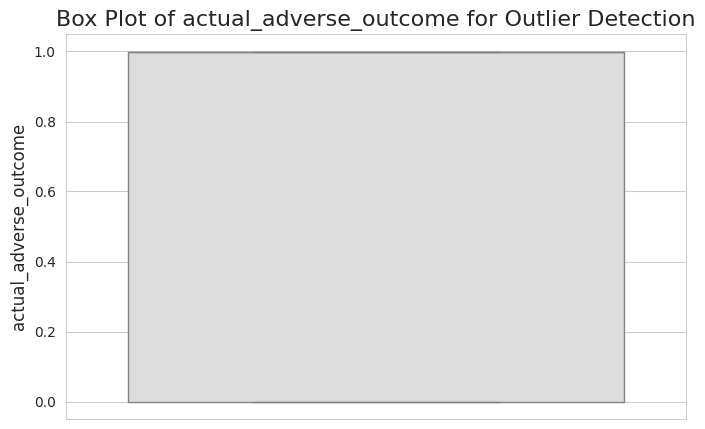

  No significant outliers detected in 'actual_adverse_outcome' based on IQR method.


<ipython-input-28-3699468975>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], palette='coolwarm')


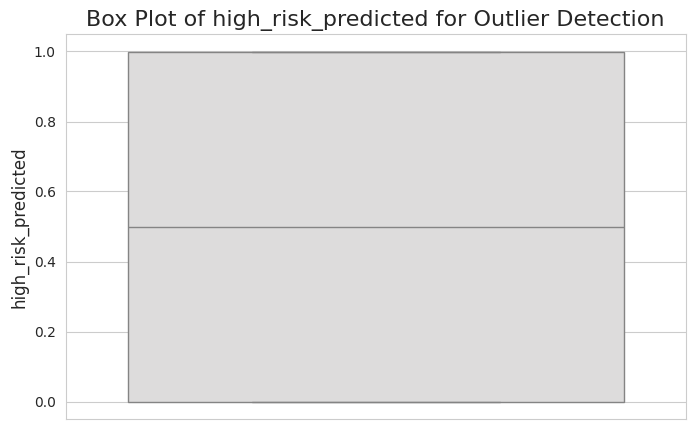

  No significant outliers detected in 'high_risk_predicted' based on IQR method.


<ipython-input-28-3699468975>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df[col], palette='coolwarm')


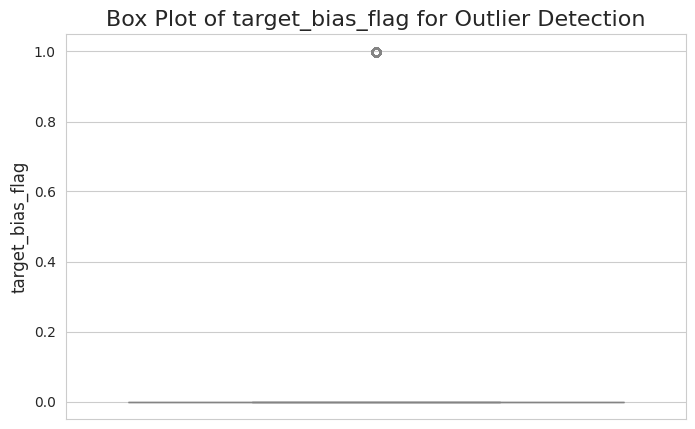

  Outliers detected in 'target_bias_flag': 120 values outside [0.00, 0.00]
  Example outliers (first 5): [1, 1, 1, 1, 1]


In [ ]:
print("--- Outlier Detection ---")
print("\nDo you observe outliers?")
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=df[col], palette='coolwarm')
    plt.title(f'Box Plot of {col} for Outlier Detection', fontsize=16)
    plt.ylabel(col, fontsize=12)
    plt.show()

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    if not outliers.empty:
        print(f"  Outliers detected in '{col}': {len(outliers)} values outside [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"  Example outliers (first 5): {outliers.head().tolist()}")
    else:
        print(f"  No significant outliers detected in '{col}' based on IQR method.")

--- Relationship Between Features and the Target ('target_bias_flag') (Numerical) ---

What is the relationship between the features and the target?

Distribution of the target variable ('target_bias_flag'):
target_bias_flag
0    0.88
1    0.12
Name: proportion, dtype: float64

Value counts for target_bias_flag:
target_bias_flag
0    880
1    120
Name: count, dtype: int64


<ipython-input-30-4007721490>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette='muted')


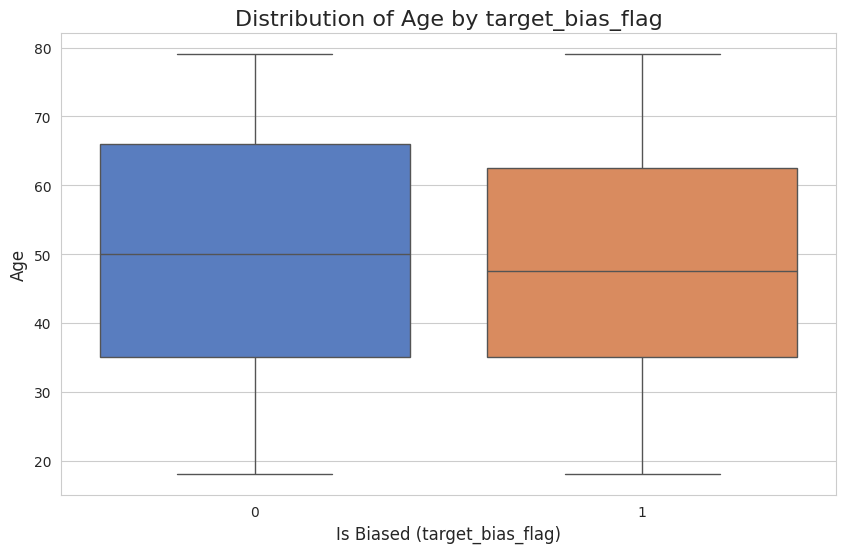

  Mean of 'Age' for target_bias_flag=0 (Not Biased): 50.09
  Mean of 'Age' for target_bias_flag=1 (Biased): 48.53


In [ ]:
print("--- Relationship Between Features and the Target ('target_bias_flag') (Numerical) ---")
print("\nWhat is the relationship between the features and the target?")
target_col = 'target_bias_flag'

print(f"\nDistribution of the target variable ('{target_col}'):")
print(df[target_col].value_counts(normalize=True))
print(f"\nValue counts for {target_col}:\n{df[target_col].value_counts()}")

# Relationship with numerical features
for col in numerical_cols:
    # Exclude target and direct components of target from this analysis for clarity
    if col != target_col and col != 'high_risk_predicted' and col != 'hypothetical_model_risk_score' and col != 'actual_adverse_outcome':
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=target_col, y=col, palette='muted')
        plt.title(f'Distribution of {col} by {target_col}', fontsize=16)
        plt.xlabel(f"Is Biased ({target_col})", fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.show()
        print(f"  Mean of '{col}' for {target_col}=0 (Not Biased): {df[df[target_col]==0][col].mean():.2f}")
        print(f"  Mean of '{col}' for {target_col}=1 (Biased): {df[df[target_col]==1][col].mean():.2f}")

--- Relationship Between Features and the Target ('target_bias_flag') (Categorical) ---


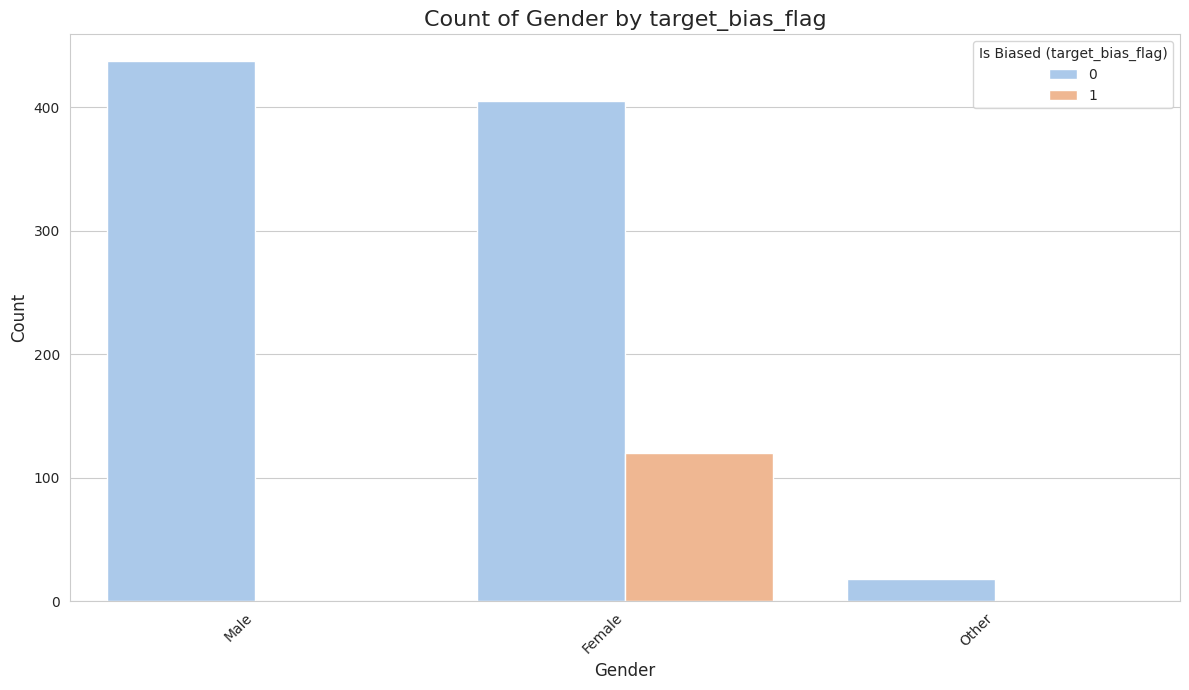


Cross-tabulation (Row Percentages) of 'Gender' and 'target_bias_flag':
target_bias_flag     0     1
Gender                      
Female            0.77  0.23
Male              1.00  0.00
Other             1.00  0.00


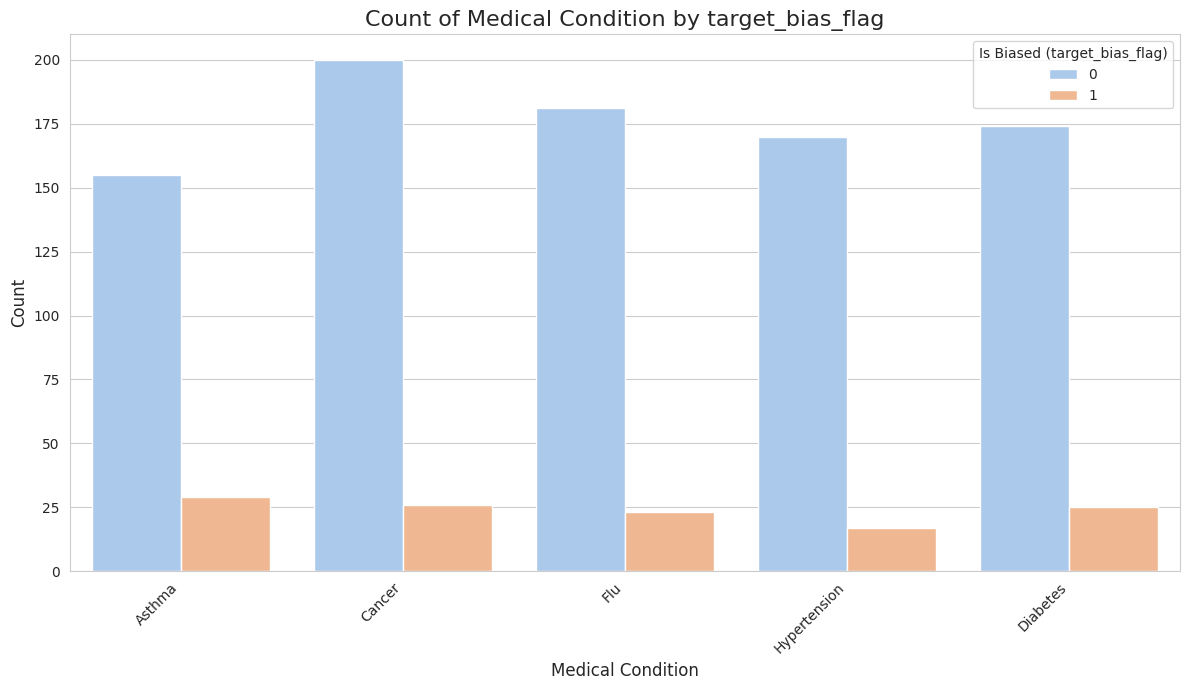


Cross-tabulation (Row Percentages) of 'Medical Condition' and 'target_bias_flag':
target_bias_flag      0     1
Medical Condition            
Asthma             0.84  0.16
Cancer             0.88  0.12
Diabetes           0.87  0.13
Flu                0.89  0.11
Hypertension       0.91  0.09


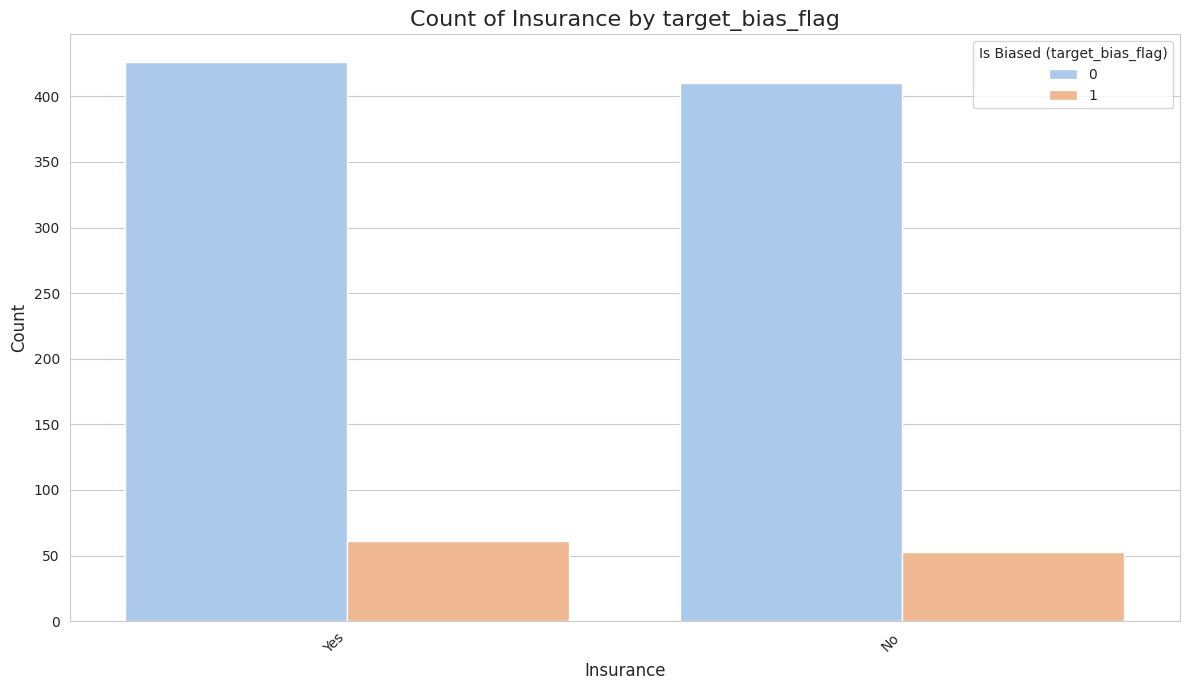


Cross-tabulation (Row Percentages) of 'Insurance' and 'target_bias_flag':
target_bias_flag     0     1
Insurance                   
No                0.89  0.11
Yes               0.87  0.13


In [ ]:
print("--- Relationship Between Features and the Target ('target_bias_flag') (Categorical) ---")
target_col = 'target_bias_flag' # Redefine for clarity if running cells independently

# Relationship with categorical features
for col in categorical_cols:
    if col != target_col: # Avoid plotting target against itself
        plt.figure(figsize=(12, 7))
        sns.countplot(data=df, x=col, hue=target_col, palette='pastel')
        plt.title(f'Count of {col} by {target_col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title=f"Is Biased ({target_col})")
        plt.tight_layout()
        plt.show()

        print(f"\nCross-tabulation (Row Percentages) of '{col}' and '{target_col}':")
        print(pd.crosstab(df[col], df[target_col], normalize='index').round(2))

In [ ]:
print("--- Train/Test Split and Preprocessing Preparation ---")
# Define features (X) and target (y) for the "classification-adjacent problem".
# Exclude columns directly used to create 'target_bias_flag' if you intend to predict bias from other features.
# 'hypothetical_model_risk_score' and 'actual_adverse_outcome' are excluded because 'target_bias_flag' is derived from them.
X = df.drop(columns=[target_col, 'hypothetical_model_risk_score', 'actual_adverse_outcome', 'high_risk_predicted'])
y = df[target_col]

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target variable value counts:\n{y.value_counts()}")

# Identify numerical and categorical features for preprocessing
numerical_features_for_model = X.select_dtypes(include=np.number).columns
categorical_features_for_model = X.select_dtypes(include='object').columns

print(f"\nFeatures identified for modeling: {numerical_features_for_model.tolist()} (numerical) and {categorical_features_for_model.tolist()} (categorical).")

# Create preprocessing pipelines for numerical (scaling) and categorical (one-hot encoding) features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_for_model),
        ('cat', categorical_transformer, categorical_features_for_model)
    ],
    remainder='passthrough' # Keep other columns if any, or 'drop'
)

# Split data into training and testing sets
# Stratify by 'y' to ensure similar proportions of 'biased'/'not biased' instances in both splits,
# which is important for imbalanced targets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n--- Data Split for Modeling ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print("\nPreprocessing (scaling and one-hot encoding) will be applied using 'preprocessor' before model training.")


--- Train/Test Split and Preprocessing Preparation ---

Features (X) shape: (1000, 4)
Target (y) shape: (1000,)
Target variable value counts:
target_bias_flag
0    880
1    120
Name: count, dtype: int64

Features identified for modeling: ['Age'] (numerical) and ['Gender', 'Medical Condition', 'Insurance'] (categorical).

--- Data Split for Modeling ---
X_train shape: (800, 4)
X_test shape: (200, 4)
y_train shape: (800,)
y_test shape: (200,)

Preprocessing (scaling and one-hot encoding) will be applied using 'preprocessor' before model training.


## Modeling Stategy Insights

**Thought Process**

This cell serves as a reflection point to synthesize EDA findings into actionable modeling strategies.

**Purpose:**

 To bridge the gap between descriptive analysis (EDA) and predictive modeling by outlining how the insights gained will guide the machine learning workflow.

**Why Here?**

It's a critical step in a data science project lifecycle, forcing the analyst to think about the practical implications of their data understanding.

**KEY COMPONENTS:**  

- It prompts for considerations regarding:
- Model Choice: Which algorithms are suitable given data characteristics (e.g., handling missing values, outliers, data types).
Preprocessing Steps: Specific transformations needed (e.g., imputation, scaling, encoding).
- Evaluation Metrics: Which metrics are most relevant for the problem, especially in the context of fairness and class imbalance.

**Answer (Applying EDA Findings to Modeling Strategy):**

Based on the EDA findings from the synthetic dataset:

**Handling Missing Values:**

- Age (5% missing),
- Gender (2% missing),
- and Insurance (5% missing) columns have missing values.

**Strategy:**

-  For Age (numerical), mean or median imputation could be considered, or a more sophisticated method like K-nearest neighbors imputation.
- For Gender and Insurance (categorical), mode imputation or adding a 'Missing' category could be appropriate. The choice will depend on the potential impact of these missing values on model performance and bias.

**Feature Engineering/Preprocessing for Categorical Variables:**

- Gender, Medical Condition, and Insurance are categorical.

**Strategy:**

OneHotEncoder will be used for these features during preprocessing to convert them into a numerical format suitable for most machine learning models. This will be integrated into a ColumnTransformer within a Pipeline.

**Outlier Handling:**

- No significant outliers were detected in the numerical features (Age, hypothetical_model_risk_score, actual_adverse_outcome, high_risk_predicted, target_bias_flag) using the IQR method.

**Strategy**
 No specific outlier treatment (like winsorization or removal) seems necessary based on this analysis, which simplifies preprocessing.

**Model Choice:**

The problem involves predicting actual_adverse_outcome and analyzing bias related to target_bias_flag. The features include a mix of numerical and one-hot encoded categorical variables.

**Strategy:**
- Logistic Regression or SVM: These could serve as baselines. For hypothetical_model_risk_score, StandardScaler might be applied if using distance-based models.

- Tree-based Models (e.g., Random Forest, Gradient Boosting Machines): Given their robustness to varying data distributions, they are good candidates. They inherently handle non-linear relationships and are less sensitive to feature scaling or outliers.

- The final choice will depend on performance and interpretability needs, especially concerning fairness.

**Evaluation Metrics (Prioritization):**

- The actual_adverse_outcome is fairly balanced (~51.5% positive). Standard classification metrics like Accuracy, Precision, Recall, and F1-score are relevant.

**Crucially for Bias Analysis:**

- The target_bias_flag indicates a significant disparity (24% of Females flagged vs. 0% for Males). This highlights a potential false positive rate disparity for the "Female" group as per the definition of the bias flag (predicted high risk but no actual adverse outcome).

- Therefore, Fairness Metrics will be paramount, particularly those addressing Equalized Odds Difference (specifically focusing on false positive rate parity) and Disparate Impact (comparing selection rates across groups).

- Metrics like ROC-AUC will also be valuable for evaluating overall model performance, especially if hypothetical_model_risk_score is the primary output of the model being evaluated for bias.

**Strategy:**

- Prioritize metrics that quantify fairness explicitly, such as Equalized Odds Difference (especially for false positives).

- Additionally, traditional metrics like F1-score and ROC-AUC will be used to assess overall predictive performance, recognizing the need to balance performance with fairness. If target_bias_flag were the target, then F1-score would be crucial due to its imbalance (12% positives).

**Addressing Bias/Hypothesis Confirmation:**

- The clear bias identified in target_bias_flag relative to Gender (Females disproportionately flagged) indicates that bias mitigation strategies may be necessary.

**Strategy:**
Explore bias mitigation techniques at different stages:
Pre-processing: Re-sampling techniques (e.g., SMOTE or ADASYN if target_bias_flag were a target), or reweighing data points.

- In-processing: Using fairness-aware algorithms or regularizers during model training.

- Post-processing: Adjusting model predictions to achieve fairness (e.g., thresholding based on group).
- Consider the implications of removing or transforming the Gender column on fairness and model performance.